# Dueling Network Architectures
> ???

- branch: 2020-04-20-dueling-network-architectures
- badges: true
- image: images/dueling-network-architectures.jpeg
- comments: true
- author: David R. Pugh
- categories: [pytorch, deep-reinforcement-learning, deep-q-networks]

I am continuing to work my way through the [Udacity](https://www.udacity.com/) [*Deep Reinforcement Learning Nanodegree*](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). In this blog post I discuss and implement an the dueling network architecture from [*Dueling Network Architectures for Deep Reinforcement Learning*](https://arxiv.org/abs/1511.06581) (Wang et al 2016).

## Background

The overall setup in [Wang et al 2016](https://arxiv.org/pdf/1511.06581.pdf) is similar to 
previous work in the deep RL literature. The agent seeks maximize the expected discounted 
return, where we define the discounted return as 

$$ R_t = \sum_{s=0}^{\infty} \gamma^s r_{t+s} $$

where $\gamma \in [0, 1]$ is a discount factor that determines how the RL agent should value 
immediate versus long-term rewards. For an RL agent behaving according to a stochastic policy 
$\pi$, the values of the state-action pair $(s, a)$ and the state $s$ are defined as follows.

\begin{align}
Q^{\pi}(s, a) =& \mathbb{E} \big[R_t \big| s_t = s, a_t = a, \pi\big] \\
V^{\pi}(s) =& \mathbb{E}_{a\sim \pi(s)}\big[Q^{\pi}(s, a)\big]
\end{align}

The preceding state-action value function, or Q function, can be computed recursively with 
dynamic programming.

$$ Q^{\pi}(s, a) = \mathbb{E}_{s'}\bigg[r + \gamma \mathbb{E}_{a'\sim \pi(s')}\big[Q^{\pi}(s', a')\big] \bigg| s, a, \pi \bigg] $$

### Advantage Function

At this point, [Wang et al 2016](https://arxiv.org/pdf/1511.06581.pdf), begin to deviate 
a bit previous work from previous work by defining an *advantage function* which relates 
the $V$ and $Q$ functions as follows.

$$ A^{\pi}(s, a) = Q^{\pi}(s, a) − V^{\pi}(s) $$

Note that assuming that the agent chooses its actions using policy $\pi$ it follows that 

$$ \mathbb{E}_{a\sim\pi(s)}\big[A^{\pi}(s, a)\big] = 0. $$

Intuitively, the value function $V$ measures how "good" it is to be in a particular state $s$. The 
$Q$ function measures the the value of choosing a particular action when in state $s$. The 
advantage function, $A$, subtracts the value of being in state $s$ from the $Q$ function to obtain 
a relative measure of the importance of each action in state $s$.

### Deep Q-Networks

[Minh et al 2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) approximate the value functions defined above using deep neural networks which they refere to as deep Q-networks. In particular Minh et al 2015 parameterize the Q-function using $Q(s, a; \theta)$ and then seek to find parameters $\theta$ of some neural network that minimize the follwing sequence of loss functions at iteration $i$:

$$ L_i(\theta_i) = \mathbb{E}_{s,a,r,s'} \bigg[y_i^{DQN} − Q(s, a; \theta_i)\bigg]^2 $$

with

$$ y_i^{DQN} = r + \gamma \underset{a'}{max}\ Q(s', a'; \theta^{-}) $$

where $\theta^{-}$ represents the parameters of a separate, target network whose parameters, because of convergence issues, are only occasionally updated. If you are interested in more details about deep Q-networks check out my [previous post](https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/03/deep-q-networks.html) (or even better read the original paper).

In the cell below I implement several useful type annotations and functions that come from Minh et al 2015 that will be used later in this post.

In [52]:
import torch
from torch import nn


States = torch.Tensor
Actions = torch.Tensor
Rewards = torch.Tensor
Dones = torch.Tensor
QNetwork = nn.Module
QValues = torch.Tensor


def synchronize_q_networks(q1: QNetwork, q2: QNetwork) -> None:
    """In place, synchronization of q1 and q2."""
    _ = q1.load_state_dict(q2.state_dict())


def select_greedy_actions(states: torch.Tensor, q_network: QNetwork) -> Actions:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states: States,
                              actions: Actions,
                              rewards: Rewards,
                              dones: Dones,
                              gamma: float,
                              q_network: QNetwork) -> QValues:
    """Compute the Q-values by evaluating the actions given the current states and Q-network."""
    next_q_values = q_network(states).gather(dim=1, index=actions)        
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values


def q_learning_update(states: States,
                      rewards: Rewards,
                      dones: Dones,
                      gamma: float,
                      q_network: QNetwork) -> QValues:
    """Q-Learning uses a q-network to select and evaluate actions."""
    actions = select_greedy_actions(states, q_network)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network)
    return q_values


### Double Deep Q-Networks

[Van Hasselt et al (2015)](https://arxiv.org/abs/1509.06461) combined double Q-learning and deep 
Q-networks to obtain a much improved algorithm called double deep Q-networks (DDQN). For more 
detailed discussion of the DDQN algorithm see either my 
[previous blog post](https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/11/double-dqn.html) 
(or better yet read the [original paper](https://arxiv.org/pdf/1509.06461.pdf)).

The DDQN algorithm uses the online Q-network parameterized by $\theta$ to choose actions but uses 
the target Q-network parameterized by $\theta^{-}$ to evaluated the chosen actions and compute the 
q-values. DDQN uses the following rule for computing the target.

$$ y_i^{DDQN} = r + \gamma Q\big(s', \underset{a'}{\mathrm{argmax}}Q(s', a'; \theta_i); \theta^{-}\big) $$

In the cell below I provide my Python implementation of this update rule.

In [53]:
def double_q_learning_update(states: States,
                             rewards: Rewards,
                             dones: Dones,
                             gamma: float,
                             q1: QNetwork,
                             q2: QNetwork) -> torch.Tensor:
    """Double Q-Learning uses q1 to select actions and q2 to evaluate the selected actions."""
    actions = select_greedy_actions(states, q1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q2)
    return q_values


### Prioritized Experience Replay

[Schaul et al (2016)](https://arxiv.org/abs/1511.05952) introduced prioritized experience replay 
which increased the replay probability of experience tuples that have a high expected learning 
progress (as measured via the proxy of absolute temporal difference (TD) error). For more details 
see my 
[previous blog post](https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/14/prioritized-experience-replay.html) 
(or better yet read the [original paper](https://arxiv.org/pdf/1511.05952.pdf)).

In the cells below I provide and implementation of the TD errors for both Q and double Q-learning 
as well a an implementation of a `PrioritizedExperienceReplayBuffer` that encapsulates the key 
ideas from Schaul et al (2016).

In [3]:
TDErrors = torch.Tensor


def q_learning_error(states: States,
                     actions: Actions,
                     rewards: Rewards,
                     next_states: States,
                     dones: Dones,
                     gamma: float,
                     q_network: QNetwork) -> TDErrors:
    """Q-learning temporal-difference (TD) error."""
    expected_q_values = q_learning_update(next_states, rewards, dones, gamma, q_network)
    q_values = q_network(states).gather(dim=1, index=actions)
    delta = expected_q_values - q_values
    return delta


def double_q_learning_error(states: States,
                            actions: Actions,
                            rewards: Rewards,
                            next_states: States,
                            dones: Dones,
                            gamma: float,
                            q1: QNetwork,
                            q2: QNetwork) -> torch.Tensor:
    """Double Q-learning temporal-difference (TD) error."""
    expected_q_values = double_q_learning_update(next_states, rewards, dones, gamma, q1, q2)
    q_values = q1(states).gather(dim=1, index=actions)
    delta = expected_q_values - q_values
    return delta


In [9]:
import collections
import typing

import numpy as np


Experiences = np.ndarray
SamplingWeights = np.array


_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)


class PrioritizedExperienceReplayBuffer:
    """Fixed-size buffer to store priority, Experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int,
                 alpha: float = 0.0,
                 beta: float = 0.0,
                 beta_annealing_schedule: typing.Callable[[int], float] = None,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        alpha (float): Strength of prioritized sampling. Default to 0.0 (i.e., uniform sampling).
        beta (float): Strength of the sampling correction. Default to 0.0 (i.e., no correction).
        random_state (np.random.RandomState): random number generator.
        
        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0 # current number of prioritized experience tuples in buffer
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("experience", Experience)])
        self._alpha = alpha
        self._beta = beta
        
        # if not provided, assume constant beta annealing schedule
        if beta_annealing_schedule is None:
            self._beta_annealing_schedule = lambda n: self._beta
        else:
            self._beta_annealing_schedule = beta_annealing_schedule
        
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        """Current number of prioritized experience tuple stored in buffer."""
        return self._buffer_length

    @property
    def alpha(self):
        """Strength of prioritized sampling."""
        return self._alpha

    @property
    def batch_size(self) -> int:
        """Number of experience samples per training batch."""
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        """Maximum number of prioritized experience tuples stored in buffer."""
        return self._buffer_size

    def add(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, experience)
            else:
                pass # low priority experiences should not be included in buffer
        else:
            self._buffer[self._buffer_length] = (priority, experience)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        """True if the buffer is empty; False otherwise."""
        return self._buffer_length == 0
    
    def is_full(self) -> bool:
        """True if the buffer is full; False otherwise."""
        return self._buffer_length == self._buffer_size
    
    def sample(self, episode_number: int) -> typing.Tuple[np.array, Experiences, SamplingWeights]:
        """Sample a batch of experiences from memory."""
        # use sampling scheme to determine which experiences to use for learning
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps**self._alpha / np.sum(ps**self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)
        
        # select the experiences and compute sampling weights
        experiences = self._buffer["experience"][idxs]
        
        # compute the sampling weights
        beta = self._beta_annealing_schedule(episode_number)
        weights = (self._buffer_length * sampling_probs[idxs])**-beta
        normalized_weights = weights / weights.max()
        
        return idxs, experiences, normalized_weights

    def update_priorities(self, idxs: np.array, priorities: np.array) -> None:
        """Update the priorities associated with particular experiences."""
        self._buffer["priority"][idxs] = priorities


## Dueling Network Architecture

The motivation for the new Q-network architecture developed by Wang et al (2016) is the observation that in many practical applications it is unnecessary to estimate the value of each action choice in every state. In some states, it is obviously critical to know which action to take (think of an autonomous vehicle about to hit a pedistrian!), but in many other states the choice of action has no real, observable impact. Bootstrapping-based RL algorithms, however, estimate the value of each action for every state.

![](my_icons/dueling-network-architectures.jpeg)

The lower layers of the network are shared and can be though of as a kind of feature extractor. Instead of following these layers with a single sequence of fully-connected, dense layers, the dueling network architecture splits into two streams of fully-connected, dense layers. One stream of fully connected layers is used to estimate the value function directly, while the second stream of layers is used to estimate the advantage function. The two streams are then re-combined using equation ??? above to estimate the Q-function.

There are some technical issues given any Q-function it is not possible to recover both V and A functions uniquely (technically, this means that the parameters $\theta^{F}, \theta^{A}, \theta^{V}$ are not identifiable from the data). In order to solve this issue Wang et al (2016) force the advantage function estimator to have zero advantage for the chosen action. That is, we let the last module of the network implement the forward mapping

$$ Q(s, a; \theta^{F}, \theta^{A}, \theta^{V}) = V (s; \theta^{F}, \theta^{V}) + \bigg(A(s, a; \theta^{F}, \theta^{A}) − \underset{a'}{\max} A(s, a'; \theta^{F}, \theta^{A})\bigg) $$ 

trying to An alternative module replaces the max operator with an
average:

$$ Q(s, a; \theta^{F}, \theta^{A}, \theta^{V}) = V (s; \theta^{F}, \theta^{V}) + \bigg(A(s, a; \theta^{F}, \theta^{A}) − \frac{1}{|A|}\sum_{a'}A(s, a'; \theta^{F}, \theta^{A})\bigg) $$ 

Since the output of the dueling network architecture is a Q-function, it can be trained with either the DQN or DDQN training algorithms and can also take advantage
of other advances such as better replay memories, better exploration policies, etc.

In the cell below I wrap up these ideas into a PyTorch `nn.Module`. All the action is in the implementation of the `forward` method of the `DuelingDeepQNetwork` module which will be used to compute the forward pass during training.

In [25]:
import typing

from torch import nn


class DuelingDeepQNetwork(nn.Module):
    
    def __init__(self,
                 advantage_q_network_fn: typing.Callable[[], QNetwork],
                 feature_extractor_q_network_fn: typing.Callable[[], QNetwork],
                 value_q_network_fn: typing.Callable[[], QNetwork]):
        super().__init__()
        
        self._advantage_q_network_fn = advantage_q_network_fn
        self._feature_extractor_q_network_fn = feature_extractor_q_network_fn
        self._value_q_network_fn = value_q_network_fn
        self._initialize()
        
    def _initialize(self):
        """Create the various Q-network instances."""
        self._feature_extractor_q_network = self._feature_extractor_q_network_fn()
        self._advantage_q_network = self._advantage_q_network_fn()
        self._value_q_network = self._value_q_network_fn()
        
        
    def clone(self) -> "DuelingDeepQNetwork":
        """Return a DuelingDeepQNetwork with the same network architecture as self."""
        q_network = DuelingDeepQNetwork(self._advantage_q_network_fn,
                                        self._feature_extractor_q_network_fn,
                                        self._value_q_network_fn)
        return q_network
        
    def forward(self, X: torch.Tensor):
        """Forward pass combines the three Q-networks."""
        Z = self._feature_extractor_q_network(X)
        advantage = self._advantage_q_network(Z)
        value = self._value_q_network(Z)
        return value + advantage - advantage.mean()
        
    def synchronize_with(self, other: "DuelingDeepQNetwork") -> None:
        """Synchronize the weights of self with those of other."""
        synchronize_q_networks(self, other)
    


## Refactoring the `DeepQAgent` class

Other than continuing to clean up internal implementation details, nothing really changed from the 
implementation of the `DeepQAgent` from my previous posts.  I added two additional parameters to 
the constructor: `alpha` which controls the strength of the prioritization sampling and 
`beta_annealing_schedule` (discussed in detail below) which allows the strength of the sampling 
bias correction (i.e., the importance sampling weights) to increase as training progresses.

The `GymState` is represented by an `np.ndarray` with shape `(210, 160, 3)` and dtype `np.uint8`. Need to convert the `GymState` into a `DeepQAgent` internal representation of state which is a `torch.Tensor` with shape `(1, 3, 210, 160)` and dtype `torch.float32`. We can accomplish this by defining a pre-processing function that takes an `ndarray` input and returns a `torch.Tensor`. This function can encapsulate what ever pre-processing steps that need to be included to convert a raw `GymState` to a suitable `torch.Tensor`.  Here I make use of the `torchvision.transforms` module which contains exactly the transformation that I need!

In [12]:
from torchvision import transforms


GymState = np.ndarray


def preprocessing_fn(state: GymState) -> torch.Tensor:
    """Converts a Gym state with shape (H, W, C) to a torch.Tensor with shape (1, C, H, W)."""
    state_tensor = (transforms.ToTensor()(state)
                              .unsqueeze(dim=0))
    return state_tensor


In [32]:
import typing

import numpy as np
import torch
from torch import nn, optim


Action = int
Reward = float
Done = bool


class Agent:
    
    def __call__(self, state: GymState) -> Action:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError
    
    def load(self, filepath) -> None:
        """Load an Agent state from a saved checkpoint."""
        raise NotImplementedError
        
    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError
        
    def step(self,
             state: GymState,
             action: Action,
             reward: Reward,
             next_state: GymState,
             done: Done) -> None:
        """Update internal state after observing effect of action on the environment."""
        raise NotImplmentedError


class DeepQAgent(Agent):

    def __init__(self,
                 dueling_dqn: DuelingDeepQNetwork,
                 replay_buffer: PrioritizedExperienceReplayBuffer,
                 preprocessing_fn: typing.Callable[[GymState], torch.Tensor],
                 optimizer_fn: typing.Callable[[typing.Iterable[nn.Parameter]], optim.Optimizer],
                 number_actions: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 gamma: float,
                 update_frequency: int,
                 seed: int = None) -> None:
        """
        Initialize a DeepQAgent.
        
        Parameters:
        -----------
        dueling_dqn (DuelingDeepQNetwork):
        optimizer_fn (callable): function that takes Q-network parameters and returns an optimizer.
        epsilon_decay_schdule (callable): function that takes episode number and returns 0 <= epsilon < 1.
        alpha (float): rate at which the target q-network parameters are updated.
        gamma (float): Controls how much that agent discounts future rewards (0 < gamma <= 1).
        update_frequency (int): frequency (measured in time steps) with which q-network parameters are updated.
        seed (int): random seed
        
        """
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False
        
        # initialize agent hyperparameters
        self._memory = replay_buffer
        self._number_actions = number_actions
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._gamma = gamma
        self._update_frequency = update_frequency
        
        # initialize Q-Networks
        self._preprocessing_fn = preprocessing_fn
        self._online_q_network = dueling_dqn
        self._target_q_network = (self._online_q_network
                                      .clone())
        self._target_q_network.synchronize_with(self._online_q_network)        
        self._online_q_network.to(self._device)
        self._target_q_network.to(self._device)
        
        # initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0
        
    def __call__(self, state: GymState) -> Action:
        """Epsilon-greedy action given the current state of the environment."""
        _state = (self._preprocessing_fn(state)
                      .to(self._device))
            
        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(_state)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(_state, epsilon)
        return action
           
    def _uniform_random_policy(self, state: torch.Tensor) -> Action:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._number_actions)
        
    def _greedy_policy(self, state: torch.Tensor) -> Action:
        """Choose action that maximizes the Q-values given the current state."""
        actions = select_greedy_actions(state, self._online_q_network)
        action = (actions.cpu()  # actions might reside on the GPU!
                         .item())
        return action
    
    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> Action:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action
    
    def _ddqn_algorithm(self,
                        idxs: np.ndarray,
                        states: torch.Tensor,
                        actions: torch.Tensor,
                        rewards: torch.Tensor,
                        next_states: torch.Tensor,
                        dones: torch.Tensor,
                        sampling_weights: torch.Tensor) -> None:
        """Double deep Q-network (DDQN) algorithm with prioritized experience replay."""

        # compute the temporal difference errors
        deltas = double_q_learning_error(states,
                                         actions,
                                         rewards,
                                         next_states,
                                         dones,
                                         self._gamma,
                                         self._online_q_network,
                                         self._target_q_network)
        
        # update experience priorities
        priorities = (deltas.abs()
                            .cpu()
                            .detach()
                            .numpy()
                            .flatten())
        self._memory.update_priorities(idxs, priorities + 1e-6) # priorities must be positive!
        
        # compute the mean squared loss
        loss = torch.mean((deltas * sampling_weights)**2)
        
        # updates the parameters of the online network
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

        # don't forget to synchronize the target and online networks
        self._target_q_network.synchronize_with(self._online_q_network) 
    
    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._memory) >= self._memory.batch_size
    
    def load(self, filepath: str) -> None:
        checkpoint = torch.load(filepath)
        self._online_q_network.load_state_dict(checkpoint["q-network-state"])
        self._target_q_network.synchronize_with(self._online_q_network)
        self._optimizer.load_state_dict(checkpoint["optimizer-state"])
    
    def save(self, filepath: str) -> None:
        """
        Saves the state of the DeepQAgent.
        
        Parameters:
        -----------
        filepath (str): filepath where the serialized state should be saved.
        
        Notes:
        ------
        The method uses `torch.save` to serialize the state of the q-network, 
        the optimizer, as well as the dictionary of agent hyperparameters.
        
        """
        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "experience_replay_buffer": {
                "alpha": self._memory.alpha,
                "batch_size": self._memory.batch_size,
                "beta_annealing_schedule": self._beta_annealing_schedule,
                "buffer_size": self._memory.buffer_size,
            },
            "agent-hyperparameters": {
                "epsilon_decay_schedule": self._epsilon_decay_schedule,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)
        
    def step(self,
             state: GymState,
             action: Action,
             reward: Reward,
             next_state: GymState,
             done: Done) -> None:
        """Update internal state after observing effect of action on the environment."""
        state_tensor = self._preprocessing_fn(state)
        next_state_tensor = self._preprocessing_fn(next_state)
        experience = Experience(state_tensor, action, reward, next_state_tensor, done)
        self._memory.add(experience) 

        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                idxs, _experiences, _sampling_weights = self._memory.sample(self._number_episodes)
                
                # unpack the experiences
                _states, _actions, _rewards, _next_states, _dones = tuple(zip(*_experiences))  
                states = (torch.cat(_states, dim=0)
                               .to(self._device))
                actions = (torch.Tensor(_actions)
                                .long()
                                .unsqueeze(dim=1)
                                .to(self._device))
                rewards = (torch.Tensor(_rewards)
                                .unsqueeze(dim=1)
                                .to(self._device))
                next_states = (torch.cat(_next_states, dim=0)
                                    .to(self._device))
                dones = (torch.Tensor(_dones)
                               .unsqueeze(dim=1)
                               .to(self._device))
                
                # reshape sampling weights
                sampling_weights = (torch.Tensor(_sampling_weights)
                                         .view((-1, 1))
                                         .to(self._device))
                
                self._ddqn_algorithm(idxs, states, actions, rewards, next_states, dones, sampling_weights)


## The Training Loop

The code for the training loop remains unchanged from previous posts.

In [14]:
import collections
import typing

import gym


Score = int


def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> Score:
    """Train agent for a maximum number of timesteps."""
    state = env.reset()
    score = 0
    for t in range(max_timesteps):
        action = agent(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

                
def _train_until_done(agent: Agent, env: gym.Env) -> Score:
    """Train the agent until the current episode is complete."""
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score


def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: Score,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[Score]:
    """
    Reinforcement learning training loop.
    
    Parameters:
    -----------
    agent (Agent): an agent to train.
    env (gym.Env): an environment in which to train the agent.
    checkpoint_filepath (str): filepath used to save the state of the trained agent.
    number_episodes (int): maximum number of training episodes.
    maximum_timesteps (int): maximum number of timesteps per episode.
    
    Returns:
    --------
    scores (list): collection of episode scores from training.
    
    """
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores


## Solving `atari` environments

In the rest of this blog post I will use the Double DQN algorithm with prioritized experience 
replay to train an agent to solve the 
[LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) environment from 
[OpenAI](https://openai.com/).

https://gym.openai.com/envs/#atari

### Google Colab Preamble

If you are playing around with this notebook on Google Colab, then you will need to run the following cell in order to install the required OpenAI dependencies into the environment.

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[atari]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


The code in the cell below creates a virtual display in the background that your Gym Envs can connect to for rendering. You can adjust the size of the virtual buffer as you like but you must set `visible=False`.

**This code only needs to be run once per session to start the display.**

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

### Binder Preamble

The code in the cell below creates a virtual display in the background that your Gym Envs can connect to for rendering. You can adjust the size of the virtual buffer as you like but you must set `visible=False`.

*This code only needs to be run once per session to start the display.*

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [15]:
import gym

env = gym.make('Atlantis-v0')
_ = env.seed(42)

### Creating a `DeepQAgent`

Before creating an instance of the `DeepQAgent` with prioritized experience replay I need to 
define a $\beta$-annealing schedule, an $\epsilon$-decay schedule, and choose an optimizer.

#### $\beta$-annealing schedule

Due to the inherent non-stationarity of the RL training process, Schaul et al 2016 hypothesize 
that a small sampling bias can be ignored during early training episodes. Instead of fixing 
$\beta=1$ (and fully correcting for the bias throughout training) they increase the amount of 
importance sampling correction as the number of training episodes increase by defining a schedule 
for $\beta$ that reaches 1 (i.e., full bias correction) only near the end of training.  

Note that the choice of $\beta$ interacts with choice of prioritization exponent $\alpha$: 
increasing both simultaneously prioritizes sampling more aggressively while at the same time as 
correcting for it more strongly.

In [18]:
# define some annealing schedue for beta
rate = 1e-2
_beta_annealing_schedule = lambda n: 1 - np.exp(-rate * n)

_replay_buffer_kwargs = {
    "alpha": 0.5,
    "beta_annealing_schedule": _beta_annealing_schedule,
    "batch_size": 64,
    "buffer_size": 1000000,
    "random_state": None
}
replay_buffer = PrioritizedExperienceReplayBuffer(**_replay_buffer_kwargs)

#### $\epsilon$-decay schedule

As was the case with the DQN and Double DQN algorithms, the agent chooses its action using an 
$\epsilon$-greedy policy. When using an $\epsilon$-greedy policy, with probability $\epsilon$, the 
agent explores the state space by choosing an action uniformly at random from the set of feasible 
actions; with probability $1-\epsilon$, the agent exploits its current knowledge by choosing the 
optimal action given that current state. 

As the agent learns and acquires additional knowledge about it environment it makes sense to 
*decrease* exploration and *increase* exploitation by decreasing $\epsilon$. In practice, it isn't 
a good idea to decrease $\epsilon$ to zero; instead one typically decreases $\epsilon$ over time 
according to some schedule until it reaches some minimum value.

In [19]:
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.99,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

#### Choosing an optimizer

Given the good results I achieved in my previous post using the [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimizer I decided to continue to use that optimizer here.

In [20]:
from torch import optim


_optimizer_kwargs = {
    "lr": 1e-3,
    "betas":(0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

### Creating a dueling Q-network architecture

Now I am ready to create an instance of the `DuelingQNetwork` class. I need to define three, no-arg functions that return the `feature_extractor_q_network`, `value_q_network` and `advantage_q_network`, respectively. I am going to use the same network structure from the paper.

* `feature_extractor_q_network` consists of three convolutional layers with ReLU activations. First convolutional layer has 32 filters each using a kernel size of 8 and a stride of 4. Second convolutional layer has 64 filters each using a kernel of size 4 and a stride of 2. The final convolutional layer also has 64 filters but uses a kernel of size 2 and a stride of 1.
* `value_q_network` consists of two layers. The first layer simply flattens the inputs from the `feature_extractor_q_network`. The second layer is just a dense, fully-connected layer followed by a ReLU activation function. The final layer of the `value_q_network` outputs a single number representing the value of a particular state.
* `advantage_q_network` also consists of two layers. The first layer flattens the inputs from the `feature_extractor_q_network`. The second layer is just a dense, fully-connected layer followed by a ReLU activation function. The final layer of the `value_q_network` has the same number of outputs as there are valid actions.



In [21]:
class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)


In [34]:
def atari_feature_extractor_q_network_fn() -> QNetwork:
    """Defines the feature extractor Q-network."""
    q_network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1),
        nn.ReLU(),
    )
    return q_network


def atari_value_q_network_fn() -> QNetwork:
    """Defines the value Q-network (computes the value of each state)."""
    q_network = nn.Sequential(
        LambdaLayer(lambda tensor: tensor.view(tensor.size(0), -1)),
        nn.Linear(in_features=25024, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=1)
    )
    return q_network


def make_atari_advantage_q_network_fn(number_actions: int) -> typing.Callable[[], QNetwork]:
    """Return a function representing the advantage Q-network."""
    
    def atari_advantage_q_network_fn() -> QNetwork:
        """Defines the advantage Q-network (computes the benefit of taking each action a given the state)."""
        q_network = nn.Sequential(
            LambdaLayer(lambda tensor: tensor.view(tensor.size(0), -1)),
            nn.Linear(in_features=25024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=number_actions)
        )
        return q_network
    
    return atari_advantage_q_network_fn


In [35]:
NUMBER_ACTIONS = (env.action_space
                     .n)

dueling_dqn = DuelingDeepQNetwork(
    make_atari_advantage_q_network_fn(NUMBER_ACTIONS),
    atari_feature_extractor_q_network_fn,
    atari_value_q_network_fn
)

### Training the `DeepQAgent`

Now I am finally ready to train the `deep_q_agent`. The target score for the `LunarLander-v2` environment is 200 points on average for at least 100 consecutive episodes. First, I will train an RL agent with $\alpha=0.0$ and $\beta=0$ (throught training) which will recover the uniform random sampling baseline. Then I will re-train the RL agent using prioritized sampling for comparison. 

#### Uniform random sampling

In [42]:
%%time
_agent_kwargs = {
    "dueling_dqn": dueling_dqn,
    "replay_buffer": replay_buffer,
    "preprocessing_fn": preprocessing_fn,
    "number_actions": NUMBER_ACTIONS,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "gamma": 0.99,
    "update_frequency": 4,
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

uniform_sampling_scores = train(double_dqn_agent,
                                env,
                                checkpoint_filepath="uniform-sampling-checkpoint.pth",
                                number_episodes=1,
                                target_score=float("inf"))

CPU times: user 11min 27s, sys: 2min 18s, total: 13min 45s
Wall time: 10min 41s


## Simulating the behavior of the trained agent

In [49]:
import matplotlib.pyplot as plt
from IPython import display


def simulate(agent: Agent, env: gym.Env, ax: plt.Axes) -> None:
    state = env.reset()
    img = ax.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)       
    env.close()
    


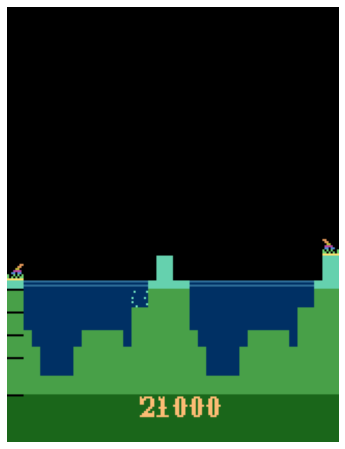

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

simulate(double_dqn_agent, env, ax)

#### Plotting the time series of scores

I can use [Pandas](https://pandas.pydata.org/) to quickly plot the time series of scores along with a 100 episode moving average. Most obvious difference between the two different sampling strategies is that prioritized sampling reduces, perhaps even eliminates, the significant number of large negative scores. Perhaps this is because prioritized sampling replays exactly those experiences that generate, at least initially, large losses (in magnitude). Over time the RL agent using prioritized sampling learns how to handle those awkward state transitions that led to *really* poor scores much better than an RL agent that uses uniform random sampling throughout.

In [40]:
uniform_sampling_scores

[15000.0,
 25700.0,
 12900.0,
 20100.0,
 15100.0,
 14500.0,
 21300.0,
 40900.0,
 27800.0,
 20300.0]

In [39]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [142]:
uniform_sampling_scores = pd.Series(uniform_sampling_scores, name="scores")
prioritized_sampling_scores = pd.Series(prioritized_sampling_scores, name="scores")

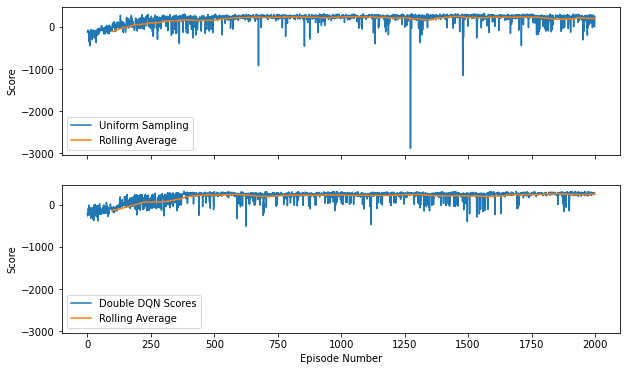

In [143]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = uniform_sampling_scores.plot(ax=axes[0], label="Uniform Sampling")
_ = (uniform_sampling_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[0]))
_ = axes[0].legend()
_ = axes[0].set_ylabel("Score")

_ = prioritized_sampling_scores.plot(ax=axes[1], label="Double DQN Scores")
_ = (prioritized_sampling_scores.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes[1]))
_ = axes[1].legend()
_ = axes[1].set_ylabel("Score")
_ = axes[1].set_xlabel("Episode Number")


#### Kernel density plot of the scores

In general, the kernel density plot will be bimodal with one mode less than -100 and a second mode 
greater than 200. The negative mode corresponds to those training episodes where the agent crash 
landed and thus scored at most -100; the positive mode corresponds to those training episodes 
where the agent "solved" the task. The kernel density or scores typically exhibits negative 
skewness (i.e., a fat left tail): there are lots of ways in which landing the lander can go 
horribly wrong (resulting in the agent getting a very low score) and only relatively few paths to 
a gentle landing (and a high score).

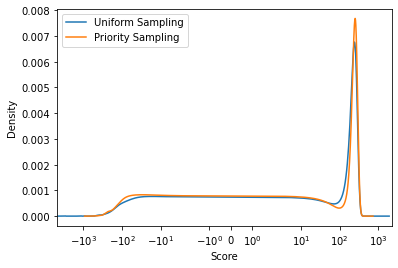

In [164]:
fig, ax = plt.subplots(1,1)
_ = uniform_sampling_scores.plot(kind="kde", ax=ax, label="Uniform Sampling")
_ = prioritized_sampling_scores.plot(kind="kde", ax=ax, label="Priority Sampling")
_ = ax.set_xlabel("Score")
_ = ax.set_xscale("symlog")
_ = ax.legend()

## Where to go from here?

Up next in this series will be [*Dueling Network Architectures for Deep Reinforcement Learning*](https://arxiv.org/abs/1511.06581). 